**Auto Encoders for Image Compression**

Step-1: Imports

Step-2: Load Dataset

Step-3: Prepare Data

Step-4: Build AutoEncoder Model

Step-5: Train AutoEncoder

Step-6: Save AutoEncoder

Step-7: Load AutoEncoder Model

Step-8: Decode Function

Step-9: Visualize Results

Step-10: Compare byte sizes

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [68]:
import os
import numpy as np
import cv2

In [2]:
!wget https://example.com/path/to/dataset.zip -O dataset.zip
!git clone https://github.com/NVlabs/ffhq-dataset.git


--2025-09-26 20:44:43--  https://example.com/path/to/dataset.zip
Resolving example.com (example.com)... 23.192.228.80, 23.192.228.84, 23.215.0.136, ...
Connecting to example.com (example.com)|23.192.228.80|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-26 20:44:44 ERROR 404: Not Found.

Cloning into 'ffhq-dataset'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 70 (delta 4), reused 4 (delta 4), pack-reused 61 (from 2)
Receiving objects: 100% (70/70), 3.88 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [3]:
!mkdir -p data/ffhq

# download all FFHQ 1024x1024 tar files listed in the text file
!wget -i ffhq-dataset/download-links-1024.txt -P data/ffhq/

ffhq-dataset/download-links-1024.txt: No such file or directory
No URLs found in ffhq-dataset/download-links-1024.txt.


In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denislukovnikov/ffhq256-images-only")

print("Path to dataset files:", path)

100%|██████████| 6.91G/6.91G [03:06<00:00, 39.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/denislukovnikov/ffhq256-images-only/versions/1


In [19]:
# make your target folder
!mkdir Images

# copy everything into data/Images
!cp -r /root/.cache/kagglehub/datasets/denislukovnikov/ffhq256-images-only/versions/1/* Images/




In [69]:

def load_data(img_dir):
  x_train = []
  image_paths = [os.path.join(img_dir,w) for w in os.listdir(img_dir) if w.endswith(".png")]
  for image_path in image_paths:
    x_train.append(cv2.imread(image_path, 0))
  return np.array(x_train)

In [70]:
import os
import cv2
import numpy as np

def load_data(img_dir, limit=200):
    x_train = []
    # List all .png files and take only the first `limit`
    image_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".png")][:limit]

    for image_path in image_paths:
        img = cv2.imread(image_path, 0)  # 0 = grayscale
        if img is not None:
            x_train.append(img)
    return np.array(x_train)

# Load only 200 images
data = load_data("/content/data/ffhq/Images/ffhq256", limit=200)
print("Loaded images:", data.shape)



Loaded images: (200, 256, 256)


In [71]:
import tensorflow as tf

# Normalize
data = data.astype('float32') / 255.

In [72]:
split = int(0.8 * len(data))
x_train = data[:split]
x_test = data[split:]

In [73]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print("Type of first image:", type(x_train[0]))
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Type of first image: <class 'numpy.ndarray'>
x_train shape: (160, 256, 256, 1)
x_test shape: (40, 256, 256, 1)


In [74]:
import tensorflow as tf
from tensorflow.keras import layers, Model, losses

In [75]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(256, 256, 1)),
            layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),  # 128x128x32
            layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),  # 64x64x64
            layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),  # 32x32x32
            layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2)   # 16x16x16
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same'),  # 32x32x32
            layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same'),  # 64x64x64
            layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same'),  # 128x128x32
            layers.Conv2DTranspose(1, (3,3), strides=2, activation='sigmoid', padding='same') # 256x256x1
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [76]:
autoencoder = AutoEncoder()
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())


In [39]:
autoencoder.encoder.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,840 (1.48 MB)

 Trainable params: 387,840 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
autoencoder.decoder.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_8              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - loss: 0.0641 - val_loss: 0.0626
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0644 - val_loss: 0.0621
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0660 - val_loss: 0.0609
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0620 - val_loss: 0.0589
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0600 - val_loss: 0.0553
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0534 - val_loss: 0.0498
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0469 - val_loss: 0.0433
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0414 - val_loss: 0.0373
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0356 - val_loss: 0.0320
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0296 - val_loss: 0.0249


In [82]:
autoencoder.save("./autoencoder_model_28x28_gray.h5")


In [83]:
from tensorflow.keras.models import load_model
autoencoder.load_weights("./autoencoder_model_28x28_gray.h5")
autoencoder.summary()

Model: "auto_encoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 16, 16, 16)     │        41,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (32, 256, 256, 1)      │        41,889 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,381 (981.96 KB)

 Trainable params: 83,793 (327.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 167,588 (654.64 KB)

In [84]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()



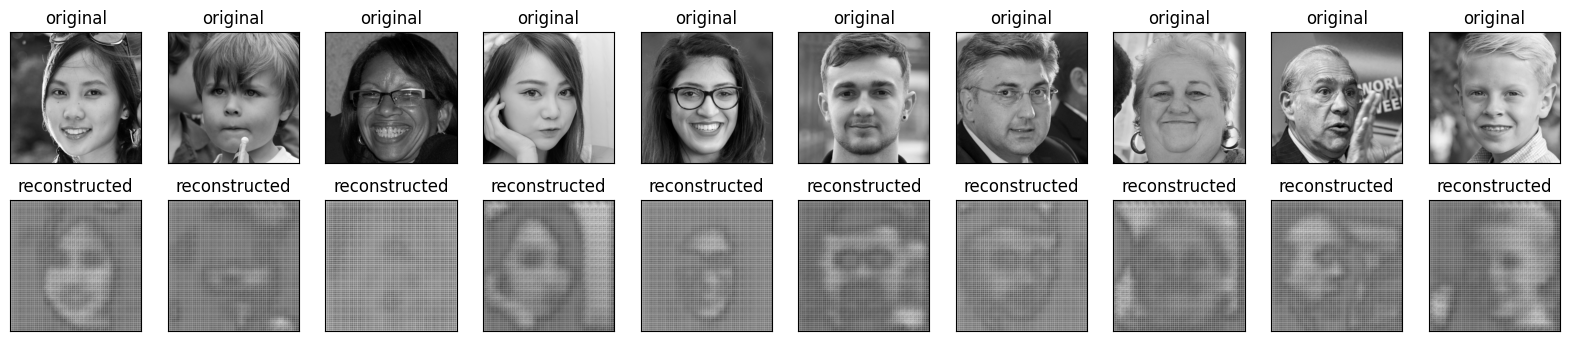

In [85]:

import matplotlib.pyplot as plt
n = 10
skip=0
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(x_test[skip+i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(decoded_imgs[skip+i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [86]:
import sys
x_test.nbytes


10485760

In [87]:
encoded_imgs.nbytes


655360

In [88]:
x_test.nbytes/encoded_imgs.nbytes


16.0

In [90]:
encoded_imgs = autoencoder.encoder(x_test[:100])
encoded_imgs_np = encoded_imgs.numpy()  # convert to NumPy array


In [91]:
original_bytes = x_test[:100].nbytes
encoded_bytes = encoded_imgs_np.nbytes

compression_ratio = original_bytes / encoded_bytes
print("Compression ratio:", compression_ratio)


Compression ratio: 16.0
